In [24]:
#Adicionar bibliotecas relevantes
%matplotlib inline
#!pip install -U -q symfit 
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.integrate import quad, simps
import scipy.signal as ss

[Bilioteca de vibrações](http://vibrationtoolbox.github.io/vibration_toolbox/index.html)

https://www.alphabold.com/fourier-transform-in-python-vibration-analysis/

# Dados de entrada

In [25]:
# Dados de entrada
m = 1000          # Massa do automóvel [kg]
k = 196*1000      # Constante elástica [N/m]
ξ = 0.1           # Fator de amortecimento [adimensional]
neta = 0.2        # Largura da parte do solo com altura Y [m]
Y = 0.1           # Amplitude da irregularidade do solo [m]
Lambda = 0.5      # Comprimeno da irregularidade correspondente a um período [m]

# Dados a serem calculados
w_n = math.sqrt(k/m)         # Fequência natural do sistema [rad/s] 
c = 2*ξ*m*w_n                # Constante de amortecimento [N*s/m]
cc = (c)/(2*m*w_n)           # Constante de amortecimento crítica [N*s/m]
w_d = w_n*math.sqrt(1-ξ*ξ)   # Frequência amortecida do sistema
 
# Definindo as velocidades
V_kmh1 = 2              # Velocidade [km/h]
V_ms1 = V_kmh1/3.6      # Velocidade [m/s]
V_kmh2 = 10             # Velocidade [km/h]
V_ms2 = V_kmh2/3.6      # Velocidade [m/s]
V_kmh3 = 72             # Velocidade [km/h]
V_ms3 = V_kmh3/3.6      # Velocidade [m/s]

# Com base nas velocidades
tau1 = Lambda/V_ms1    # Período para a velocidade 1 [s]
tau2 = Lambda/V_ms2    # Período para a velocidade 2 [s]
tau3 = Lambda/V_ms3    # Período para a velocidade 3 [s]
tt1 = neta/V_ms1       # Tempo para percorrer a parte elevada na velocidade 1 [s]
tt2 = neta/V_ms2       # Tempo para percorrer a parte elevada na velocidade 2 [s]
tt3 = neta/V_ms3       # Tempo para percorrer a parte elevada na velocidade 3 [s]

# Frequências de excitação com base na velocidade 
w1 = 2*np.pi*V_ms1/Lambda  # Frequência para velocidade 1 [rad/s]
w2 = 2*np.pi*V_ms2/Lambda  # Frequência para velocidade 2 [rad/s]
w3 = 2*np.pi*V_ms3/Lambda  # Frequência para velocidade 3 [rad/s]

# Razão entre frequência de excitação e frequência natural
r1 = w1 / w_n    # Razão de excitação para velocidade 1 [adimensional]
r2 = w2 / w_n    # Razão de excitação para velocidade 2 [adimensional]
r3 = w3 / w_n    # Razão de excitação para velocidade 3 [adimensional]

print(w_n,c,w_d)

14.0 2800.0 13.929824119492679


# METÓDO NOVO

# Questão 2

In [26]:
def plot_graph(x, y, label, label_x, label_y, title):
  plt.figure(figsize=(20, 8))
  plt.plot(x,y,label=label)
  plt.xlabel(label_x)
  plt.ylabel(label_y)
  plt.legend(loc='upper right',prop={'size':10})
  plt.title(title)
  plt.show()

In [27]:
def solver(V_kmh, nf=40, t_max=3, plot=False):
  '''
  nf = número de termos das séries de Fourrier
  V_kmh = Velocidade [km/h]
  t_max = tempo em segundos
  plot = [bool] plotar ou não os gráficos
  '''
  # Definindo as velocidades
  V_ms = V_kmh/3.6      # Velocidade [m/s]
  # Com base nas velocidades
  w = 2*np.pi*V_ms/Lambda  # Frequência de excitação [rad/s]
  r = w / w_n    #  Razão entre frequência de excitação e frequência natural [adimensional]

  tau = Lambda/V_ms if V_ms else 0   # Período para a velocidade 3 [s]
  tt = neta/V_ms if V_ms else 0     # Tempo para percorrer a parte elevada na velocidade 1 [s]

  y = 0
  F = 0
  xp = 0
  Xn = 0

  t = np.linspace(0, t_max, 10000)

  for n in range(1,nf+1):

    # Deslocamente da base y(t)
    an = ((2*Y)/(n*tau*w))*np.sin(n*w*tt)
    bn = (-(2*Y)/(n*tau*w))*(np.cos(n*w*tt)-1)
    y += an*np.cos(n*w*t) + bn*np.sin(n*w*t)

    # Força F(t) = cy' + ky oriunda da equação do movimento
    ann = k*an + c*bn*n*w
    bnn = k*bn - c*an*n*w
    F += ann*np.cos(n*w*t) + bnn*np.sin(n*w*t)

    # Resposta permanente
    sigma_n = np.arctan((2*ξ*n*r)/(1-(n*r)**2))
    annn = (ann/k)/(np.sqrt(((1-(n*r)**2)**2)+((2*n*r*ξ)**2)))
    bnnn = (bnn/k)/(np.sqrt(((1-(n**2)*(r**2))**2)+ (2*n*r*ξ)**2))
    xp += (annn*np.cos(n*w*t - sigma_n)) + (bnnn*np.sin(n*w*t - sigma_n))

    # Amplitude da resposta permanente
    Xn += np.sqrt((annn**2) + (bnnn**2))


  a0 = 2*Y*neta/Lambda
  a00 = a0*k

  y += a0/2
  F += a00/2
  xp += a00/(2*k) 

  if plot:
    plot_graph(x=t, y=y, label='Fourier v1', label_x='t [s]', label_y='y(t) [m]', title='Deslocamento da base')
    plot_graph(x=t, y=F, label='Fourier da força', label_x='t [s]', label_y='f(t) [N]', title='Magnitude da força')
    plot_graph(x=t, y=xp, label='ξ=0,1', label_x='t [s]', label_y='y(t) [m]', title='Deslocamento da base')

  return t, y, F, xp, Xn

In [28]:
t, y1, F1, xp1, _ = solver(V_kmh=2)
_, y2, F2, xp2, _ = solver(V_kmh=10)
_, y3, F3, xp3, _ = solver(V_kmh=72)

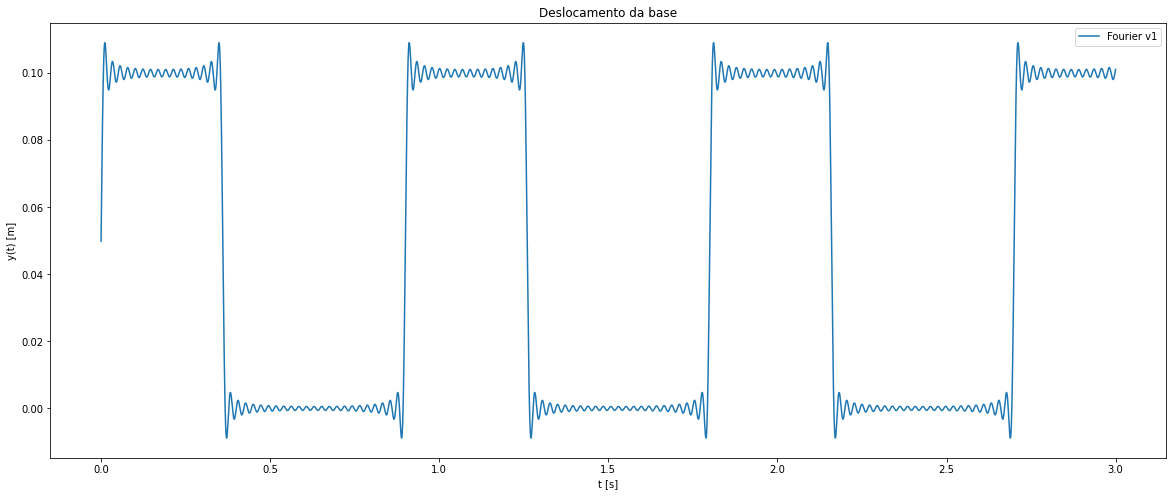

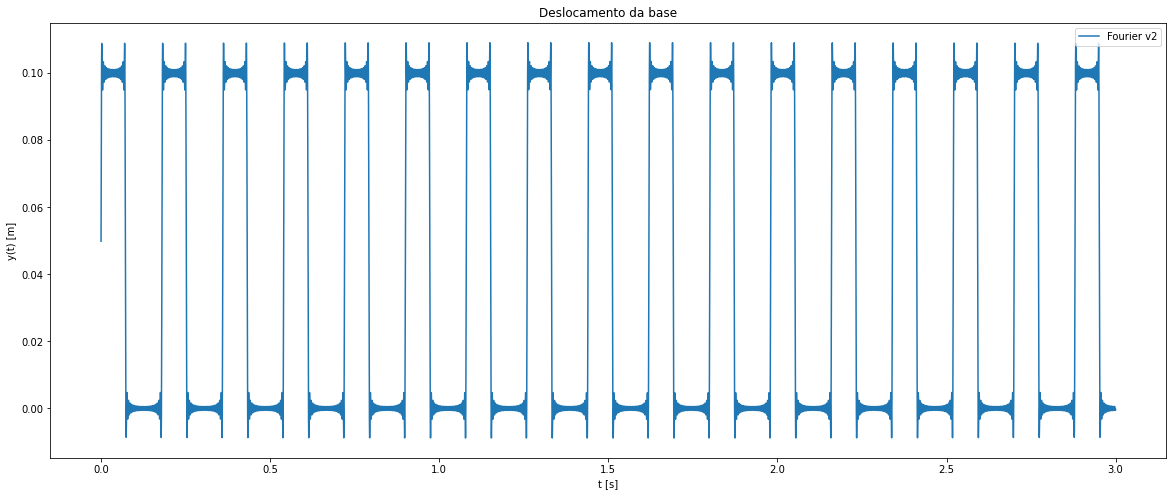

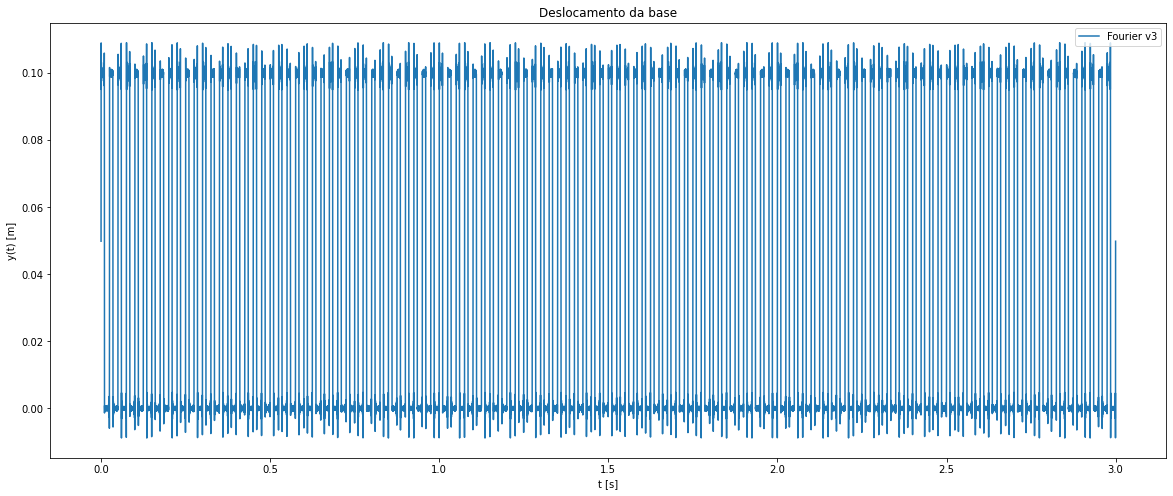

In [29]:
# Plotting deslocamento da base
plot_graph(x=t, y=y1, label='Fourier v1', label_x='t [s]', label_y='y(t) [m]', title='Deslocamento da base')
plot_graph(x=t, y=y2, label='Fourier v2', label_x='t [s]', label_y='y(t) [m]', title='Deslocamento da base')
plot_graph(x=t, y=y3, label='Fourier v3', label_x='t [s]', label_y='y(t) [m]', title='Deslocamento da base')

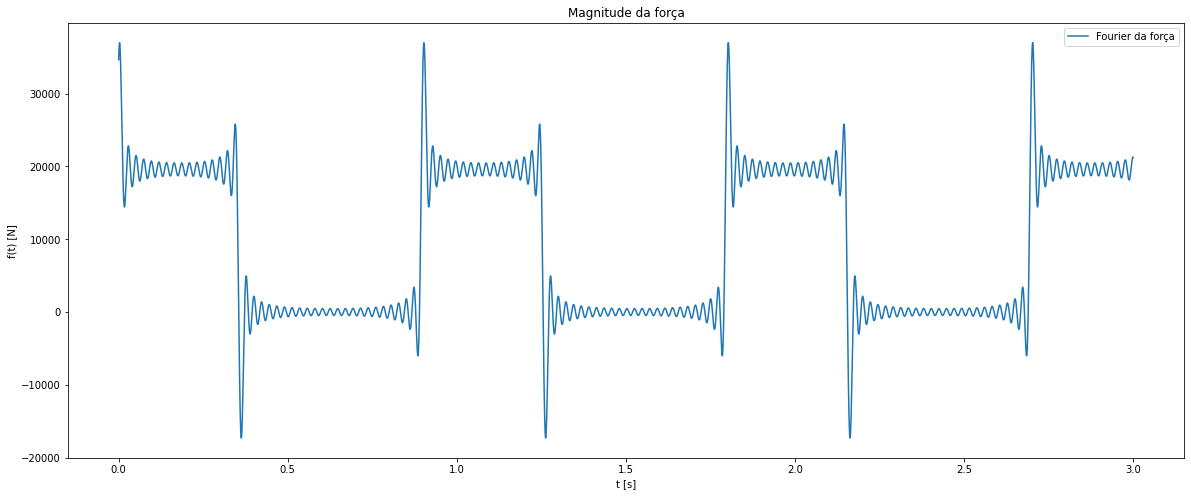

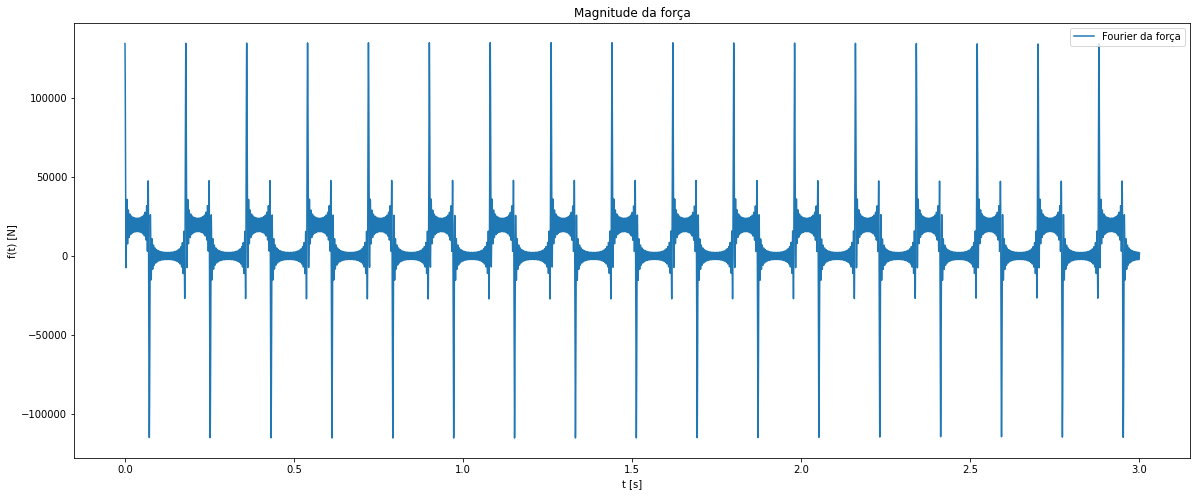

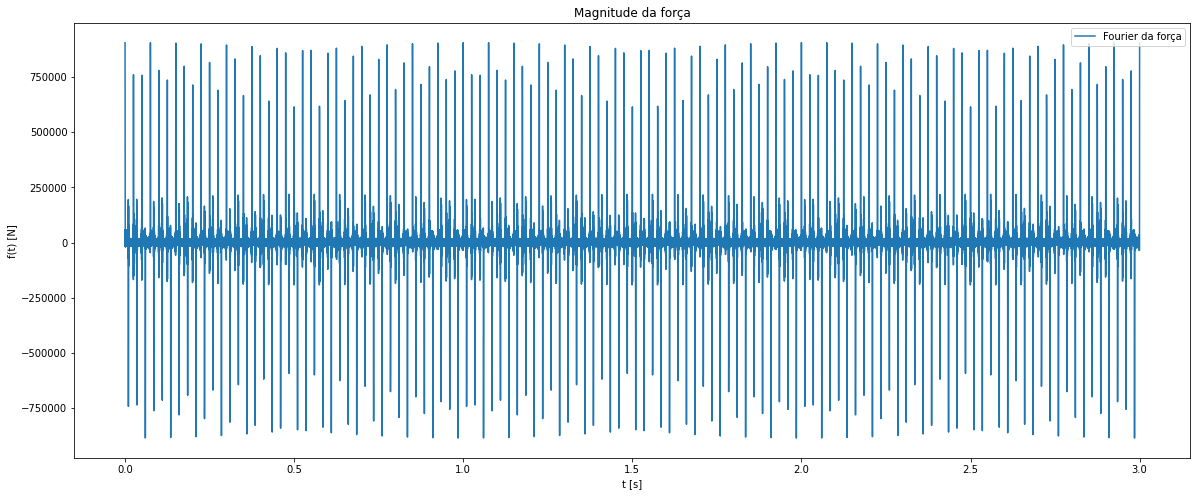

In [30]:
# Plotting magnitude da força
plot_graph(x=t, y=F1, label='Fourier da força', label_x='t [s]', label_y='f(t) [N]', title='Magnitude da força')
plot_graph(x=t, y=F2, label='Fourier da força', label_x='t [s]', label_y='f(t) [N]', title='Magnitude da força')
plot_graph(x=t, y=F3, label='Fourier da força', label_x='t [s]', label_y='f(t) [N]', title='Magnitude da força')

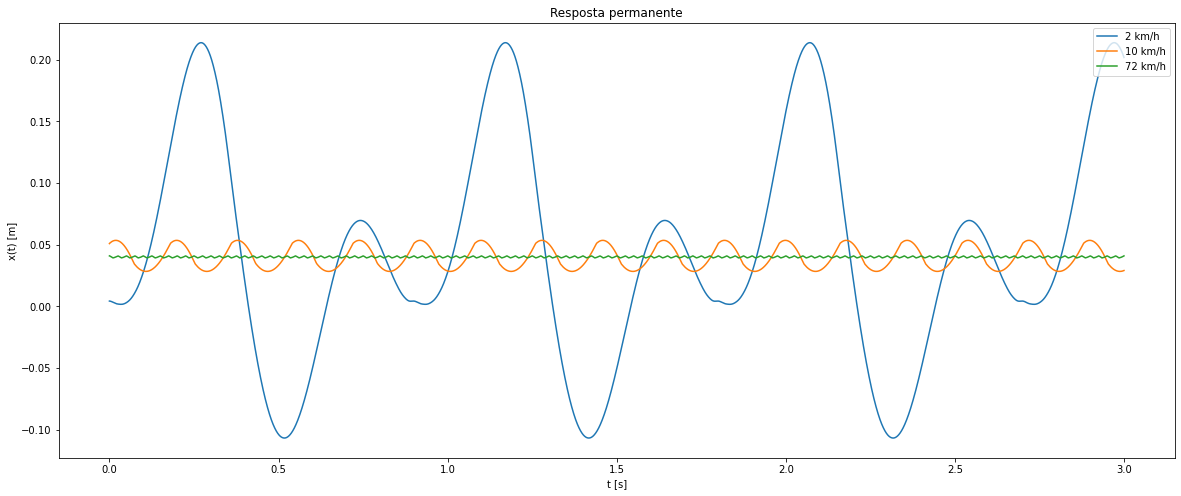

In [31]:
# Plotting resposta permanente
plt.figure(figsize=(20, 8))
plt.plot(t,xp1,label="2 km/h")
plt.plot(t,xp2,label="10 km/h")
plt.plot(t,xp3,label="72 km/h")
plt.xlabel("t [s]")
plt.ylabel("x(t) [m]")
plt.legend(loc='upper right',prop={'size':10})
plt.title("Resposta permanente")
plt.show()

# Questão 3

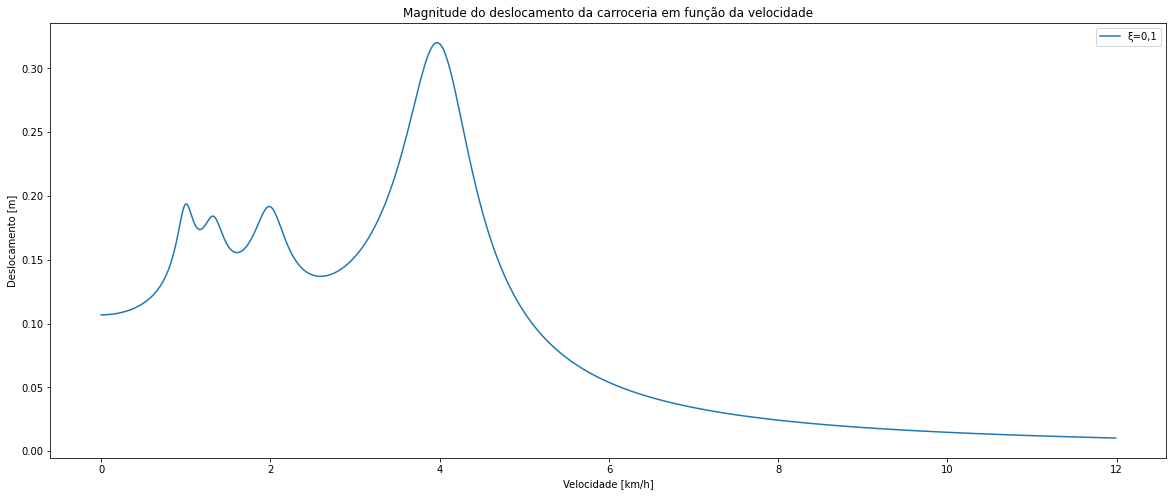

In [32]:
velocidade = np.linspace(0.00000001, 12, 1000, endpoint=False)

amp_array = []
for vel in velocidade:
  _, _, _, _, amp = solver(V_kmh=vel, nf=5)
  amp_array.append(amp)

plot_graph(x=velocidade, y=amp_array, label="ξ=0,1", label_x='Velocidade [km/h]',
           label_y="Deslocamento [m]", title='Magnitude do deslocamento da carroceria em função da velocidade')

# Método antigo

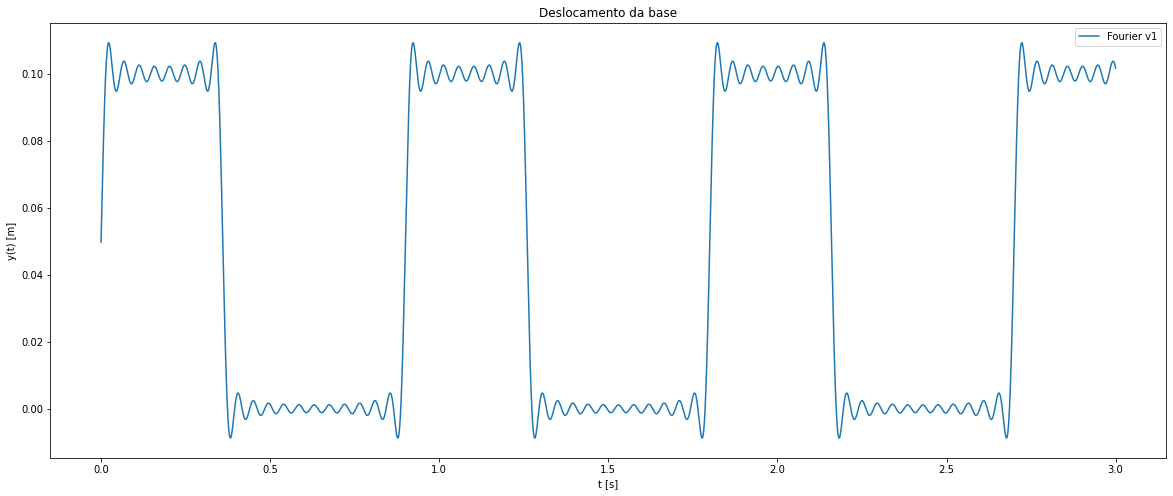

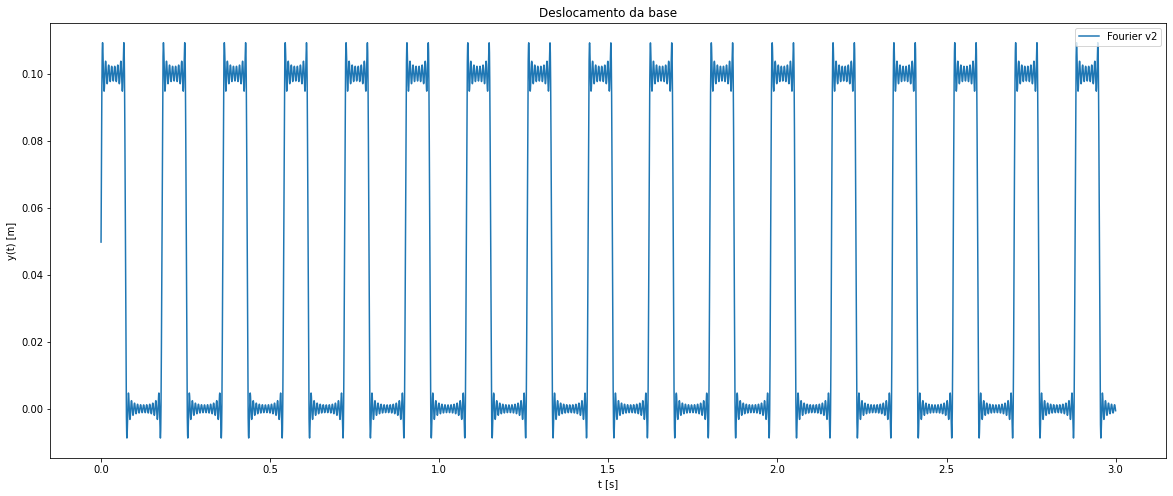

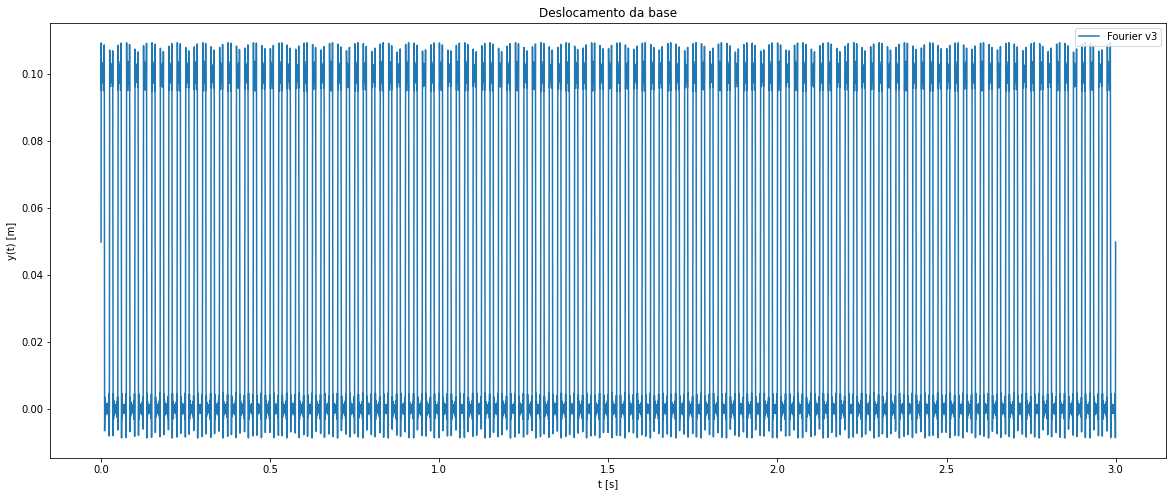

In [33]:
# Dados para as séries de Fourier

def fourier_y1(y1, an1, bn1, n, w1, t): 
    return y1 + an1*np.cos(n*w1*t) + bn1*np.sin(n*w1*t)
def fourier_y2(y2, an1, bn1, n, w2, t): 
    return y2 + an1*np.cos(n*w2*t) + bn1*np.sin(n*w2*t)
def fourier_y3(y3, an1, bn1, n, w3, t): 
    return y3 + an1*np.cos(n*w3*t) + bn1*np.sin(n*w3*t)

def fourier_F1(F1, ann1, bnn1, n, w1, t): 
    return F1 + ann1*np.cos(n*w1*t) + bnn1*np.sin(n*w1*t)
def fourier_F2(F2, ann2, bnn2, n, w2, t): 
    return F2 + ann2*np.cos(n*w2*t) + bnn2*np.sin(n*w2*t)
def fourier_F3(F3, ann3, bnn3, n, w3, t): 
    return F3 + ann3*np.cos(n*w3*t) + bnn3*np.sin(n*w3*t)

def xp_1_f(xp_1, t, ann1, bnn1, n, w1, sigma_n1, ξ, r1):
    '''
    Resposta permanente xp(t)
    xp_1 = somatório para n = n-1
    ann1 = ann para velocidade 1 
    bnn1 = bnn para velocidade 1 
    '''
    an_atual = (ann1/k)/(np.sqrt(((1-(n*r1)**2)**2)+((2*n*r1*ξ)**2)))
    bn_atual = (bnn1/k)/(np.sqrt(((1-(n**2)*(r1**2))**2)+ (2*n*r1*ξ)**2))
    return xp_1 + (an_atual*np.cos(n*w1*t - sigma_n1)) + (bn_atual*np.sin(n*w1*t - sigma_n1))                          
def xp_2_f(xp_2, t, ann2, bnn2, n, w2, sigma_n2, ξ, r2):
    an_atual = (ann2/k)/(np.sqrt(((1-(n*r2)**2)**2)+((2*n*r2*ξ)**2)))
    bn_atual = (bnn2/k)/(np.sqrt(((1-(n**2)*(r2**2))**2)+ (2*n*r2*ξ)**2))
    return xp_2 + (an_atual*np.cos(n*w2*t - sigma_n2)) + (bn_atual*np.sin(n*w2*t - sigma_n2))
def xp_3_f(xp_3, t, ann3, bnn3, n, w3, sigma_n3, ξ, r3):
    an_atual = (ann3/k)/(np.sqrt(((1-(n*r3)**2)**2)+((2*n*r3*ξ)**2)))
    bn_atual = (bnn3/k)/(np.sqrt(((1-(n**2)*(r3**2))**2)+ (2*n*r3*ξ)**2))
    return xp_3 + (an_atual*np.cos(n*w3*t - sigma_n3)) + (bn_atual*np.sin(n*w3*t - sigma_n3))

nf = 20 # Número de termos da série de Fourier

y1 = 0
y2 = 0
y3 = 0
F1 = 0
F2 = 0
F3 = 0
xp_1 = 0
xp_2 = 0
xp_3 = 0

Y_f1 = []    # lista com os valores do deslocamento fouries em cada instande de tempo para velocidade 1
Y_f2 = []    # lista com os valores do deslocamento fouries em cada instande de tempo para velocidade 2
Y_f3 = []    # lista com os valores do deslocamento fouries em cada instande de tempo para velocidade 3

F_f1 = []    # lista com os valores da força fouries em cada instande de tempo para velocidade 1
F_f2 = []    # lista com os valores da força fouries em cada instande de tempo para velocidade 2
F_f3 = []    # lista com os valores da força fouries em cada instande de tempo para velocidade 3

X_f1 = []    # lista com os valores da resposta permanente em cada instande de tempo para velocidade 1
X_f2 = []    # lista com os valores da resposta permanente em cada instande de tempo para velocidade 2
X_f3 = []    # lista com os valores da resposta permanente em cada instande de tempo para velocidade 3

tempos = []  # lista com os instantes de tempo

t_max = 3 # tempo em segundos

for t in np.linspace(0, t_max, 10000):
    for n in range(1,nf+1):
        
        # Deslocamente da base y(t)
        an1 = ((Y)/(n*np.pi))*np.sin(2*n*neta*np.pi/Lambda)
        bn1 = ((Y)/(n*np.pi))*(1-np.cos(2*n*neta*np.pi/Lambda))
        y1 = fourier_y1(y1, an1, bn1, n, w1, t)
        y2 = fourier_y2(y2, an1, bn1, n, w2, t)
        y3 = fourier_y3(y3, an1, bn1, n, w3, t)

        # Força F(t) = cy' + ky oriunda da equação do movimento
        ann1 = k*an1 + c*bn1*n*w1
        bnn1 = k*bn1 - c*an1*n*w1
        ann2 = k*an1 + c*bn1*n*w2
        bnn2 = k*bn1 - c*an1*n*w2
        ann3 = k*an1 + c*bn1*n*w3
        bnn3 = k*bn1 - c*an1*n*w3
        F1 = fourier_F1(F1, ann1, bnn1, n, w1, t)
        F2 = fourier_F2(F2, ann2, bnn2, n, w2, t)
        F3 = fourier_F3(F3, ann3, bnn3, n, w3, t)

        # Resposta permanente
        sigma_n1 = np.arctan((2*ξ*n*r1)/(1-(n*r1)**2))
        sigma_n2 = np.arctan((2*ξ*n*r2)/(1-(n*r2)**2))
        sigma_n3 = np.arctan((2*ξ*n*r3)/(1-(n*r3)**2))

        xp_1 = xp_1_f(xp_1, t, ann1, bnn1, n, w1, sigma_n1, ξ, r1)
        xp_2 = xp_2_f(xp_2, t, ann2, bnn2, n, w2, sigma_n2, ξ, r2)
        xp_3 = xp_3_f(xp_3, t, ann3, bnn3, n, w3, sigma_n3, ξ, r3)

    a0 = 2*Y*neta/Lambda
    a00 = a0*k

    Y_f1.append(y1 + a0/2)
    Y_f2.append(y2 + a0/2)
    Y_f3.append(y3 + a0/2)

    F_f1.append(F1 + a00/2)
    F_f2.append(F2 + a00/2)
    F_f3.append(F3 + a00/2)

    X_f1.append(xp_1 + a00/(2*k))
    X_f2.append(xp_2 + a00/(2*k))
    X_f3.append(xp_3 + a00/(2*k))
    
    y1=0
    y2=0
    y3=0
    F1=0
    F2=0
    F3=0
    xp_1=0
    xp_2=0
    xp_3=0

    tempos.append(t)
   
# Plotting deslocamento da base
plot_graph(x=tempos, y=Y_f1, label='Fourier v1', label_x='t [s]', label_y='y(t) [m]', title='Deslocamento da base')
plot_graph(x=tempos, y=Y_f2, label='Fourier v2', label_x='t [s]', label_y='y(t) [m]', title='Deslocamento da base')
plot_graph(x=tempos, y=Y_f3, label='Fourier v3', label_x='t [s]', label_y='y(t) [m]', title='Deslocamento da base')

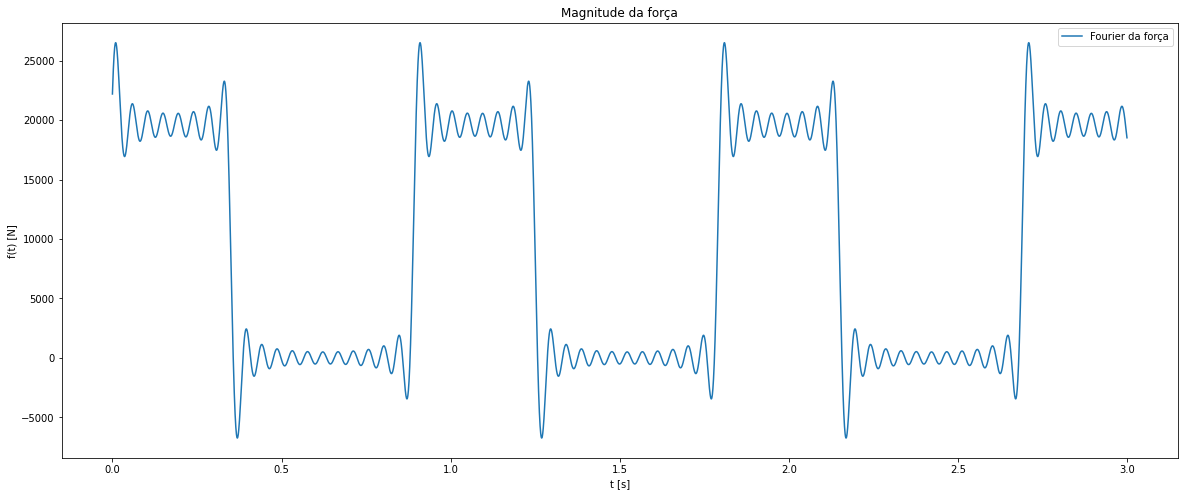

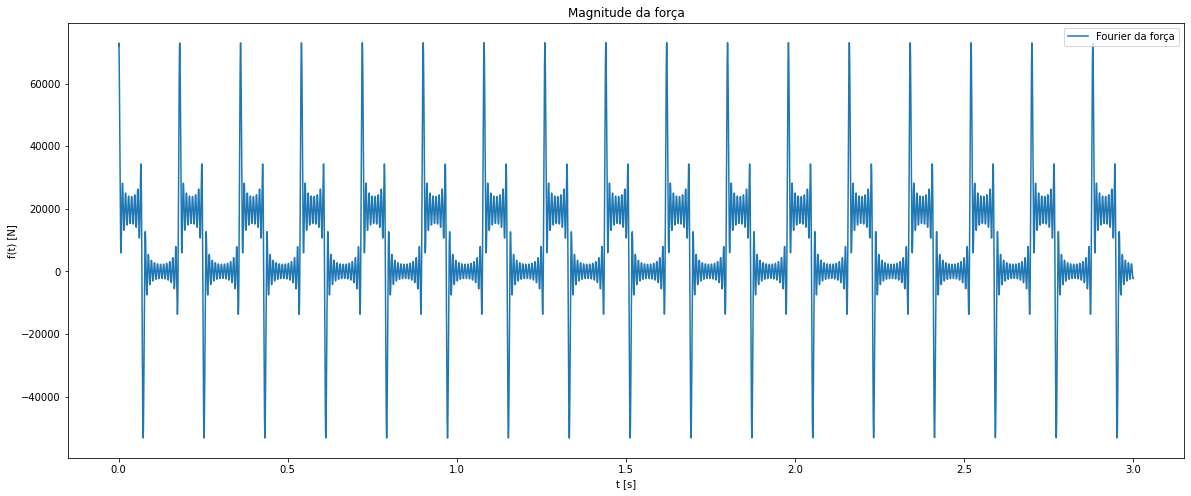

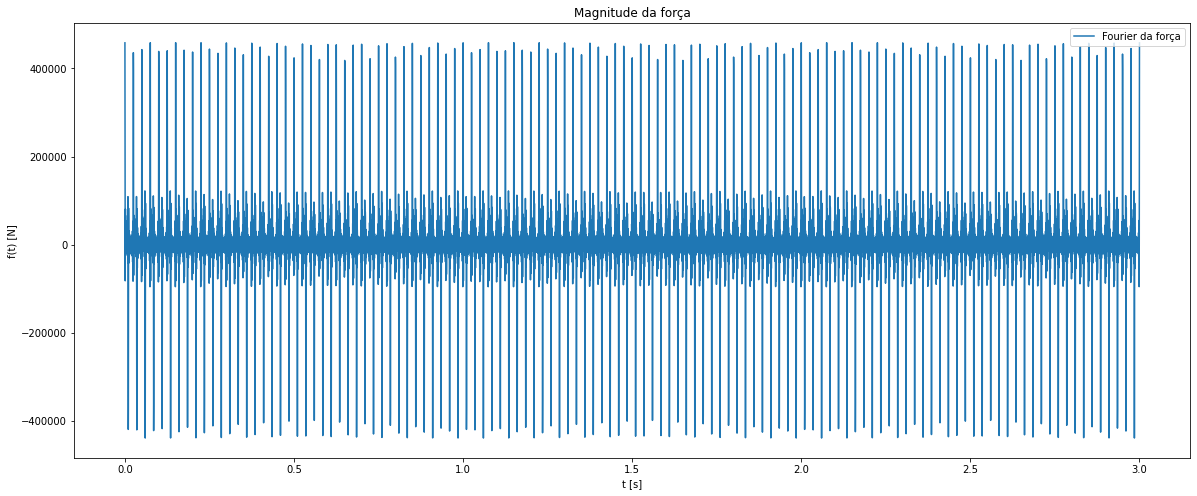

In [34]:
# Plotting magnitude da força
plot_graph(x=tempos, y=F_f1, label='Fourier da força', label_x='t [s]', label_y='f(t) [N]', title='Magnitude da força')
plot_graph(x=tempos, y=F_f2, label='Fourier da força', label_x='t [s]', label_y='f(t) [N]', title='Magnitude da força')
plot_graph(x=tempos, y=F_f3, label='Fourier da força', label_x='t [s]', label_y='f(t) [N]', title='Magnitude da força')

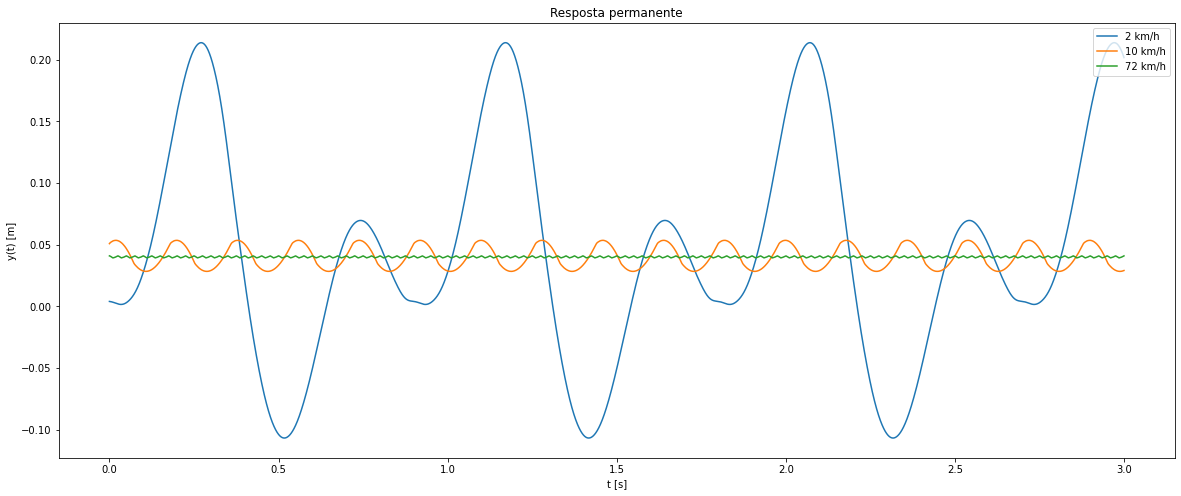

In [35]:
# Plotting resposta permanente
plt.figure(figsize=(20, 8))
plt.plot(tempos,X_f1,label="2 km/h")
plt.plot(tempos,X_f2,label="10 km/h")
plt.plot(tempos,X_f3,label="72 km/h")
plt.xlabel("t [s]")
plt.ylabel("y(t) [m]")
plt.legend(loc='upper right',prop={'size':10})
plt.title("Resposta permanente")
plt.show()